<a href="https://colab.research.google.com/github/dxbezerra/tvdi/blob/master/TVDI_projeto_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cálculo do TVDI para o estado do Ceará — uma estimativa de seca em Python**

Autores: Diego Xavier, Gustavo Nagel, Raíssa Teixeira, Stella Coelho. 

Disciplina de Introdução à Programação (SER-307) - 2019

Instituto Nacional de Pesquisas Espaciais (INPE)


---
O índice TVDI (Temperature-Vegetation Dryness Index) é um índice de estresse hídrico baseado na relação entre a temperatura da superfície e o índice de vegetação. Assim, ao integrar o NDVI (Normalized Difference Vegetation Index) e a temperatura de superfície, o TVDI é capaz de estimar o grau da seca de uma localidade, utilizando dados na faixa do visível, infra-vermelho próximo e termal (SANDHOLT et al, 2002). Este índice é de extrema importância para o monitoramento dos períodos de seca de uma região, e pode ser facilmente obtido com dados de sensoriamento remoto nas faixas espectrais citadas. 	
Neste sentido, o seguinte programa tem o objetivo de operacionalizar o monitoramento de seca agrícola para o estado do Ceará a partir de dados orbitais do sensor MODIS, apresentando um exemplo para a segunda quinzena de Setembro no ano de 2018, sendo um período de poucas chuvas no estado. O TVDI obtido pode ser assim aplicado para qualquer período em que estejam disponíveis os dados do sensor MODIS, e se combinado com dados de precipitação provenientes de estações meteorológicas é capaz de gerar informação extremamente relevante para uma localidade.

![alg](https://docs.google.com/uc?export=download&id=1x-u197nO0fc5QyZcH0Fr2W9hmWYM7wji)


As etapas para a obtenção do TVDI consistem de:
1.   Download das Imagens
2.   Extração das bandas de interesse das imagens
3.   Mosaicagem
4.   Recorte para área de interesse
5.   Acesso das imagens
6.   Tratamento dos dados
7.   Cálculo das retas
8.   Cálculo do TVDI





In [1]:
# Importar módulos
import gdal
from gdalconst import *
import numpy as np
from glob import glob
import scipy
from scipy.stats import gaussian_kde
from os import path as osp
import os, calendar, itertools, subprocess
from pymodis import downmodis
from pymodis.convertmodis_gdal import convertModisGDAL
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.basemap import Basemap

WxPython missing, no GUI enabled


In [3]:
# Criar diretório dos dados
path = './raw_data'
if not osp.exists(path):
    os.mkdir(path)

# **1. Download das imagens**
A partir da biblioteca pyModis realizamos o download das imagens de interesse. No caso, utilizamos o produto MOD13A2 que corresponde ao índices de vegetação NDVI e EVI composto de 16 dias e o produto MOD11A2 correspondente a Temperature Superficial do Solo (TS) para de um intervalo de 8 dias.
O período analisado é referente ao dia juliano 257 (segunda quinzena de Setembro), que é o período mais seco no estado do Ceará.

In [4]:
# Usuário e senha Earthdata
user     = 'grupo_tvdi'
password = 'Ninguempodesaber1'

# Cenas e produtos a serem baixados
tiles    = 'h14v09','h13v09'
products = ['MOD13A2.006', 'MOD11A2.006']

# Período selecionado
day     = '2018-09-14'
enddate = '2018-09-29'

# Download
print('Realizando download...')

for p in products:
  modisDown = downmodis.downModis(destinationFolder=path,
  password=password, user=user, tiles=tiles, product=p, today=day,
  enddate=enddate)

  modisDown.connect()
  modisDown.downloadsAllDay()

print('Download completo.')

# Checkar imagens baixadas e o seu tamanho em megabytes
fls = sorted(glob(path + '/*.hdf'))
for f in fls:
  print(osp.basename(f),'-', osp.getsize(f)/10e5, 'MB')

Realizando download...
Download completo.
MOD11A2.A2018257.h13v09.006.2018266035239.hdf - 6.701147 MB
MOD11A2.A2018257.h14v09.006.2018266035104.hdf - 3.322762 MB
MOD11A2.A2018265.h13v09.006.2018282164825.hdf - 6.699373 MB
MOD11A2.A2018265.h14v09.006.2018282165559.hdf - 3.339318 MB
MOD13A2.A2018257.h13v09.006.2018282125001.hdf - 19.171178 MB
MOD13A2.A2018257.h14v09.006.2018282125732.hdf - 7.887101 MB


# **2. Extração das bandas de interesse das imagens**
Tendo em vista que as imagens MODIS são contidas de diversas bandas (ex.: banda de qualidade do pixel, presença de nuvens, ângulo solar zenital, etc.), as bandas de interesse  são primeiramente extraídas com o módulo *convertModisGDAL*. Para o produto MOD13A2 utilizamos o NDVI e para o produto MOD11A2 a banda utilizada é a do TS capturado durante o dia (*LST_Day_1km*), ambos sendo a primeira banda.

In [5]:
# Selecionar as datas julianas únicas das imagens baixadas (np.unique seleciona apenas valores que não se repetem)
juliandays = np.unique([osp.basename(f).split(".")[1][-3:] for f in fls])

# Diretório de saída das bandas
path = './processed'
if not osp.exists(path):
  os.mkdir(path)

# Extrair bandas  
for f in fls:
  
  # Banda selecionada (Seleciona somente a primeira banda)
  subset = "1"
  
  # Extrair bandas com pymodis (obs: epsg é o código de reprojeção da imagem)
  fileout = osp.join(path, osp.basename(f)[:-4])
  extr = convertModisGDAL(f, fileout, subset, res=None, outformat='GTiff', epsg=4326)
  extr.run(quiet=True)
   
# Checkar bandas extraídas
fls = sorted(glob(path + '/*.tif'))
for f in fls:
  print(osp.basename(f))

MOD11A2.A2018257.h13v09.006.2018266035239_LST_Day_1km.tif
MOD11A2.A2018257.h14v09.006.2018266035104_LST_Day_1km.tif
MOD11A2.A2018265.h13v09.006.2018282164825_LST_Day_1km.tif
MOD11A2.A2018265.h14v09.006.2018282165559_LST_Day_1km.tif
MOD13A2.A2018257.h13v09.006.2018282125001_1 km 16 days NDVI.tif
MOD13A2.A2018257.h14v09.006.2018282125732_1 km 16 days NDVI.tif


#**3. Mosaicagem**
As imagens baixadas são correspondentes às cenas do MODIS (h14v09 e h13v09) e necessitam que sejam combinadas para o Estado do Ceará. Esse processo é realizado selecionando as imagens de mesmo produto e período, porém de cenas distintas. Mais adiante o GDAL é utilizado para criar o mosaico.

In [12]:
# Listas
products   = ['MOD13A2.006', 'MOD11A2.006']
juliandays = np.unique([osp.basename(f).split(".")[1][-3:] for f in fls])

# Selecionar imagens de mesmo produto e período, porém de cenas distintas
for p in products:
  p = p.split(".")[0]
  
  for jd in juliandays:

    # Selecionar todas as imagens criadas no passo anterior (bandas extraídas) para o mesmo produto
    glb = glob('./processed/{0}*.tif'.format(p))

    # Guardar imagens de cenas distintas de mesmo produto e de mesmo período em uma lista
    pair = []
    for im in glb:
      if jd in im:
        pair.append(im)
    
    # Se a lista de imagens não for vazia, prosseguir.
    if not pair == []:
    
      # Remover espaços no nome do arquivo (pra não dar problema com o GDAL)
      rm_spaces = pair[0].replace(" ", "")
      
      # Criar um novo nome para arquivo de saída
      fname = rm_spaces[:-4] + ".MOSAIC.vrt"

      # Criar mosaico com o GDAL utilizando o shell
      gdal.BuildVRT(fname, pair)
      translateCmd = 'gdal_translate -of GTiff {0} {1}.tif'.format(fname, fname[:-4])
      subprocess.call(translateCmd, shell=True)

# Checkar mosaicos criados
fls = sorted(glob(path + '/*MOSAIC.tif'))
for f in fls:
  print(osp.basename(f))

MOD11A2.A2018257.h14v09.006.2018266035104_LST_Day_1km.MOSAIC.tif
MOD11A2.A2018265.h13v09.006.2018282164825_LST_Day_1km.MOSAIC.tif
MOD13A2.A2018257.h13v09.006.2018282125001_1km16daysNDVI.MOSAIC.tif


# **4. Recorte para área de interesse**
Para focarmos somente na área de nosso interesse, realizamos um recorte utilizando o arquivo *shapefile* dos limites estaduais do Ceará, evitando assim o processamento de dados irrelevantes posteriormente.

In [13]:
# Arquivo shapefile
shp = './shapefiles/limites_estaduais_ce.shp'
print(os.path.isfile(shp))

# Realizar corte a partir dos mosaicos da pasta dos arquivos processados
for f in fls:
  
  # Nome do arquivo da imagem recortada
  fname = f[:-4] + ".CLIP.tif"

  # Realizar recorte com gdalwarp utilizando o shell do computador
  warpCmd = 'gdalwarp -dstnodata -3000 -cutline {0} {1} {2}\
            -crop_to_cutline -overwrite'.format(shp, f, fname)
  subprocess.call(warpCmd, shell=True)

# Checkar recortes criados
fls = sorted(glob(path + '/*CLIP.tif'))
for f in fls:
  print(osp.basename(f))

True
MOD11A2.A2018257.h14v09.006.2018266035104_LST_Day_1km.MOSAIC.CLIP.tif
MOD11A2.A2018265.h13v09.006.2018282164825_LST_Day_1km.MOSAIC.CLIP.tif
MOD13A2.A2018257.h13v09.006.2018282125001_1km16daysNDVI.MOSAIC.CLIP.tif


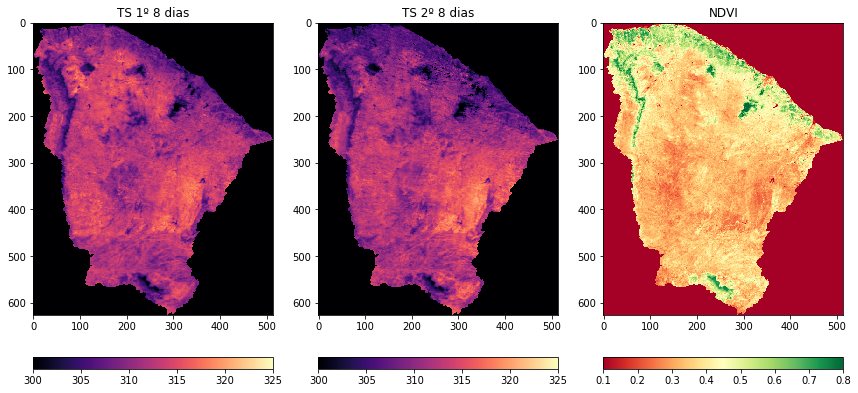

In [14]:
# Plot das imagens recortadas
dset_tss1, dset_tss2, dset_ndvi = gdal.Open(fls[0], GA_ReadOnly),\
                                  gdal.Open(fls[1], GA_ReadOnly),\
                                  gdal.Open(fls[2], GA_ReadOnly)

tss1_band, tss2_band, ndvi_band = dset_tss1.GetRasterBand(1),\
                                  dset_tss2.GetRasterBand(1),\
                                  dset_ndvi.GetRasterBand(1)

plt.figure(figsize=(12, 12))

plt.subplot(131)
plt.title("TS 1º 8 dias")
plt.imshow(tss1_band.ReadAsArray() * 0.02, cmap='magma', vmin=300, vmax=325)
plt.colorbar(orientation="horizontal", pad=0.05)

plt.subplot(132)
plt.title("TS 2º 8 dias")
plt.imshow(tss2_band.ReadAsArray() * 0.02, cmap='magma', vmin=300, vmax=325)
plt.colorbar(orientation="horizontal", pad=0.05)

plt.subplot(133)
plt.title("NDVI")
plt.imshow(ndvi_band.ReadAsArray() * 0.0001, cmap='RdYlGn', vmin=0.1, vmax=0.8)
plt.colorbar(orientation="horizontal", pad=0.05)

plt.tight_layout(pad=1)
plt.show()

dset_tss1, dset_tss2, dset_ndvi = None, None, None

# **5. Acesso as  imagens**
Para igualar o período observado entre as imagens de NDVI e TS, nesta seção é realizada uma média temporal das duas imagens TS de 8 dias. 

In [16]:
fls = sorted(glob(path + '/*CLIP.tif'))

# Carregar imagens de temperatura
dset_tss1 = gdal.Open(fls[0], GA_ReadOnly)
dset_tss2 = gdal.Open(fls[1], GA_ReadOnly)

dset_tss1_band = dset_tss1.GetRasterBand(1)
dset_tss2_band = dset_tss2.GetRasterBand(1)

# Multiplicar pelo fator de escala
dset_tss1_array = dset_tss1_band.ReadAsArray() * 0.02
dset_tss2_array = dset_tss2_band.ReadAsArray() * 0.02

# Criar máscara (substituir np.nan para valores de 0, que são os valores inválidos)
dset_tss1_array[dset_tss1_array == 0] = np.nan
dset_tss2_array[dset_tss2_array == 0] = np.nan

# Calcular média temporal ignorando nan
stack_2d = np.array([dset_tss1_array, dset_tss2_array])
TS      = scipy.nanmean(stack_2d, axis=0) # média: 311.56830648359954

# Fechar datasets
dset_tss1, dset_tss2 = None, None

# Arredondar para duas casas decimais o valor médio de TS
TS = np.round(TS, 2)

O acesso à imagem de NDVI segue da seguinte forma:

In [128]:
# Carregar imagem de NDVI
dset_ndvi = gdal.Open(fls[2], GA_ReadOnly)
ndvi_band = dset_ndvi.GetRasterBand(1)

# Armazenar informações
gt        = dset_ndvi.GetGeoTransform()
proj      = dset_ndvi.GetProjectionRef()
dtype     = ndvi_band.DataType

# Multiplicar pelo fator de escala
NDVI      = ndvi_band.ReadAsArray() * 0.0001

# Criar máscara (substituir np.nan para valores de 0, que são os valores inválidos)
NDVI[NDVI == -0.3] = np.nan

# Fechar dataset
dset_ndvi = None

# Arredondar para duas casas decimais e printar valor médio de NDVI
NDVI = np.round(NDVI, 2)

Visualização das imagens escaladas e histogramas:

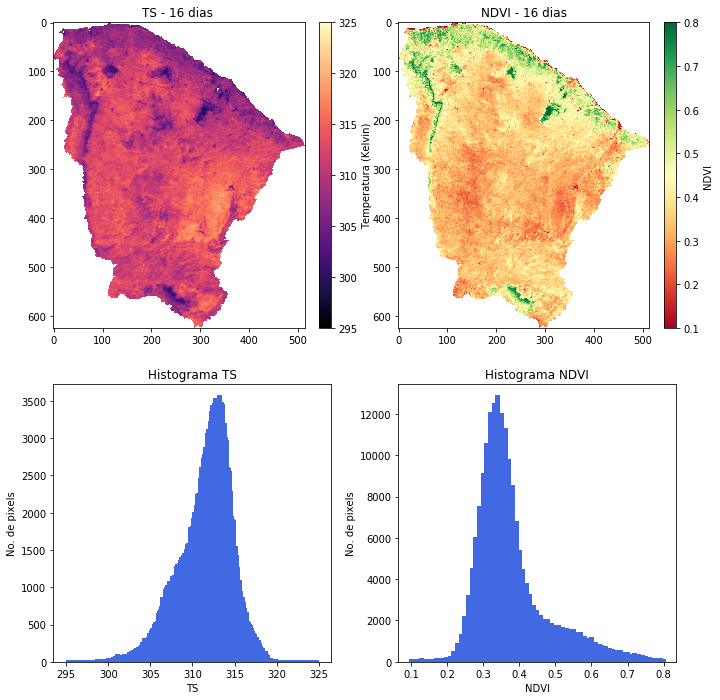

In [23]:
# Criar diretório dos dados finais
path = './output_final'
if not osp.exists(path):
    os.mkdir(path)

# Tamanho do plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
plt.subplots_adjust(left=0.125, right = 0.9, wspace=0.3)

# Subplot TS
img1 = ax1.imshow(TS, cmap='magma', vmin=295, vmax=325)
ax1.set_title("TS - 16 dias ")
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(img1, cax=cax1)
cbar.set_label("Temperatura (Kelvin)")

# Subplot NDVI
img2 = ax2.imshow(NDVI, cmap='RdYlGn', vmin=0.1, vmax=0.8)
ax2.set_title("NDVI - 16 dias")
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(img2, cax=cax2)
cbar.set_label("NDVI")

# Subplot Histograma TS
img3 = ax3.hist(TS.ravel(), bins=256, range=(295, 325), lw=4, ec='royalblue')
ax3.set_aspect(1./ax3.get_data_ratio())
ax3.set_title("Histograma TS")
ax3.set_xlabel('TS')
ax3.set_ylabel('No. de pixels')

# Subplot Histograma NDVI
img4 = ax4.hist(NDVI.ravel(), bins=256, range=(0.1, 0.8), lw=4, ec='royalblue')
ax4.set_aspect(1./ax4.get_data_ratio())
ax4.set_title("Histograma NDVI")
ax4.set_xlabel('NDVI')
ax4.set_ylabel('No. de pixels')

# Remover bordas da figura
fig.tight_layout()
fig.savefig(path + '/TS_NDVI_16days_hist.png', dpi=300)
fig.show()

# **6. Tratamento dos dados**
Antes da extração do TVDI, os valores de TS fora de 3 desvios padrões foram removidos para melhor representação dos limiares úmido e seco. Além disso, os valores de NDVI menores que zero foram eliminados pois tendem a ser representativos de corpos d'àgua.

Eliminar outliers

In [24]:
# Retirar valores fora de 3 desvios padrões da imagem de TS
std  = np.nanstd(TS) # desvio padrão
mean = np.nanmean(TS) # média

lower_limit = mean - (std*3)
upper_limit = mean + (std*3)

np.where(TS, TS < lower_limit, np.nan)
np.where(TS, TS > upper_limit, np.nan)

print("Limiar mínimo:", np.nanmin(TS), "K")
print("Limiar máximo:", np.nanmax(TS), "K")

# Retirar valores menores que zero na imagem de NDVI
NDVI[NDVI < 0] = np.nan

Limiar mínimo: 298.25 K
Limiar máximo: 320.41 K


# **7. Cálculo das retas**

Para o cálculo das retas, primeiramente são determinadas as temperaturas correspondentes ao mesmo valor de NDVI. Então são estabelecidas as temperaturas máxima e mínima para cada NDVI.

![TVDI](https://docs.google.com/uc?export=download&id=1A81JkeXKesyWRklvICWCuh0bsOey7MGE)Fonte: Du et al. (2017)



Retirada dos valores máximos e mínimos de TS

In [25]:
# Listas para mínimos (limite úmido) e máximos de TS (limite seco)
MiniList    = []
MaxList     = []
# Criar um vetor de NDVI (0 a 1 com espaçamento de 0.01)
NDVI_vector = np.round(np.arange(0.01, 1.01, 0.01), 2)

# Primeiramente são encontrados os valores de TS para mesmo NDVI
for val in NDVI_vector:
  TS_vector_val = []
  row, col = np.where(NDVI == val) # extrair index
  
  # Com a localização destes NDVIs, retiramos os valores de temperatura
  # correspondentes a estas posições (linhas e colunas)
  for i in range(len(row)):
    if np.isfinite(TS[row[i], col[i]]):
      TS_vector_val += [TS[row[i], col[i]]]
  
  # Se houver valores de TS para o NDVI desejado, é retirado os
  # valores máximo e mínimo
  if TS_vector_val != []:
    TS_min_val = np.min(TS_vector_val)
    TS_max_val = np.max(TS_vector_val)
  else:
    TS_min_val = np.nan
    TS_max_val = np.nan

  # Os valores encontrados são adicionados na listas MiniList e MaxList
  MiniList += [TS_min_val]
  MaxList  += [TS_max_val]
  
print("Valores mínimos", "- len:", len(MiniList))
print(MiniList)
print("Valores máximos", "- len:", len(MaxList))
print(MaxList)
print("Valores de NDVI", "- len:", len(NDVI_vector))
print(list(NDVI_vector))

Valores mínimos - len: 100
[299.44, 304.72, 304.92, 304.71, 301.12, 301.6, 299.56, 302.83, 299.72, 300.89, 303.9, 301.11, 301.23, 300.72, 303.98, 300.31, 301.45, 302.83, 301.96, 300.92, 301.62, 301.02, 302.3, 301.13, 302.53, 301.02, 302.35, 301.17, 302.74, 301.63, 298.77, 302.84, 301.0, 302.51, 301.12, 300.45, 302.13, 299.98, 300.4, 301.1, 302.32, 302.78, 301.14, 301.68, 302.22, 301.17, 300.86, 300.62, 301.55, 301.05, 299.92, 301.21, 301.26, 301.37, 299.98, 301.08, 300.11, 301.37, 300.13, 299.22, 301.8, 300.4, 300.35, 300.08, 301.11, 300.32, 299.72, 300.03, 299.56, 300.81, 299.86, 299.01, 298.93, 299.56, 299.66, 299.96, 299.43, 299.82, 299.02, 299.8, 298.34, 298.73, 298.47, 299.03, 298.45, 298.59, 298.25, 299.0, nan, nan, 302.05, nan, nan, nan, nan, nan, nan, nan, nan, nan]
Valores máximos - len: 100
[306.25, 305.82, 309.67, 307.07, 310.56, 307.73, 309.76, 311.21, 311.49, 314.41, 313.03, 311.18, 312.75, 313.31, 313.22, 314.41, 317.82, 315.77, 318.03, 318.65, 319.66, 319.64, 320.19, 320

Retirar coeficientes *a* e *b* para cálculo do TVDI

In [112]:
# Reta minimo
MiniList_fin = []
NDVI_fin = []

for i, val in enumerate(MiniList):
  if np.isfinite(val):
    MiniList_fin += [val]
    NDVI_fin += [NDVI_vector[i]]
print(MiniList_fin)
print(NDVI_fin)

  # Retirar coeficientes
MinPfit = np.polyfit(NDVI_fin[17:], MiniList_fin[17:], 1)
print(MinPfit)

# Reta maximo
MaxList_fin = []
NDVI_fin = []
for i, val in enumerate(MaxList):
  if np.isfinite(val):
    MaxList_fin += [val]
    NDVI_fin += [NDVI_vector[i]]
print(MaxList_fin)
print(NDVI_fin)


  # Retirar coeficientes
MaxPfit = np.polyfit(NDVI_fin[17:], MaxList_fin[17:], 1)
print(MaxPfit)

[299.44, 304.72, 304.92, 304.71, 301.12, 301.6, 299.56, 302.83, 299.72, 300.89, 303.9, 301.11, 301.23, 300.72, 303.98, 300.31, 301.45, 302.83, 301.96, 300.92, 301.62, 301.02, 302.3, 301.13, 302.53, 301.02, 302.35, 301.17, 302.74, 301.63, 298.77, 302.84, 301.0, 302.51, 301.12, 300.45, 302.13, 299.98, 300.4, 301.1, 302.32, 302.78, 301.14, 301.68, 302.22, 301.17, 300.86, 300.62, 301.55, 301.05, 299.92, 301.21, 301.26, 301.37, 299.98, 301.08, 300.11, 301.37, 300.13, 299.22, 301.8, 300.4, 300.35, 300.08, 301.11, 300.32, 299.72, 300.03, 299.56, 300.81, 299.86, 299.01, 298.93, 299.56, 299.66, 299.96, 299.43, 299.82, 299.02, 299.8, 298.34, 298.73, 298.47, 299.03, 298.45, 298.59, 298.25, 299.0, 302.05]
[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0

Visualizar gráfico de dispersão

Text(0.5, 1.0, 'NDVI vs TS Scatterplot')

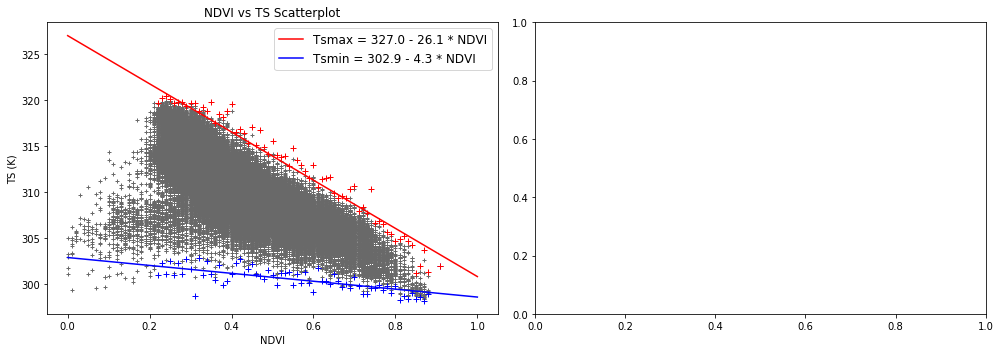

In [121]:
# gerar o primeiro e o último pontos do limite úmido e limite seco
a1, b1 = MaxPfit
a2, b2 = MinPfit
linhamax = [b1 + (a1 * 0), b1 + (a1 * 1)]
linhamin = [b2 + (a2 * 0), b2 + (a2 * 1)]

# Scatterplot das retas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), tight_layout=True)

ax1.plot(NDVI.ravel(), TS.ravel(), "+", color='dimgray', markersize=4)
ax1.plot(NDVI_vector[21:], MiniList[21:], '+', color='b')
ax1.plot(NDVI_vector[21:], MaxList[21:], '+', color='r')
ax1.plot([0, 1], linhamax, color='r', markersize=8,\
                 label=f"Tsmax = {'%.1f'% b1} - {'%.1f' % abs(a1)} * NDVI")
ax1.plot([0, 1], linhamin, color='b', markersize=8,\
                 label=f"Tsmin = {'%.1f' % b2} - {'%.1f' % abs(a2)} * NDVI")
ax1.legend(loc='upper right', fontsize=12)

# Scatterplot de densidade
# NDVIlista, Templista = [], []

# for b in range(shape[0]): # linhas
#     for c in range(shape[1]): # Colunas
#         if np.isfinite(TS[b][c]) and np.isfinite(NDVI[b][c]):
#             NDVIlista += [NDVI[b][c]]
#             Templista += [TS[b][c]]

# NDVIlista, Templista = np.array(NDVIlista), np.array(Templista)
# print(NDVIlista, Templista)

# xy = np.vstack([NDVIlista, Templista])
# z  = gaussian_kde(xy, bw_method=30)(xy)
# ax2.scatter(NDVIlista, Templista, c=z, s=8, edgecolor='')
         
# Salvar figura
fig.savefig(path + '/TS_NDVI_scatterplot.png', dpi=200)
fig.show()
ax1.set_xlabel("NDVI")
ax1.set_ylabel("TS (K)")
ax1.set_title("NDVI vs TS Scatterplot")

# **8. Cálculo do TVDI**

![TVDI](https://docs.google.com/uc?export=download&id=1nh-vaYSW5A-g5N2uour3zTiABSmvv86z)

O índice calcula a proporção entre a temperatura do pixel em questão e  os limites seco e úmido representados pelas retas. O TVDI varia de 0 a 1, sendo que quanto mais próximo de 1 maior é o nível de seca da região.

In [125]:
# Gerar matriz do TVDI a partir dos coeficientes da reta
a1, b1 = MaxPfit
a2, b2 = MinPfit

Ts_max = b1 + (a1 * NDVI)
Ts_min = b2 + (a2 * NDVI)

TVDI = (TS - Ts_min) / (Ts_max - Ts_min)
print(np.nanmin(TVDI))
print(np.nanmax(TVDI))

-0.18492313115362283
1.338740698205995


Salvar imagem do TVDI em formato GeoTIFF



In [126]:
# Gerar arquivo GeoTIFF
fname_out   = './output_final/TVDI_ce.tif'
driver      = gdal.GetDriverByName('GTiff')
data_type   = ndvi_band.DataType
dset_output = driver.Create(fname_out, NDVI.shape[1], NDVI.shape[0], 1, gdal.GDT_Float32)
dset_output.SetGeoTransform(gt)
dset_output.SetProjection(proj)
dset_output.GetRasterBand(1).WriteArray(TVDI)
dset_output.FlushCache()
dset_output = None

Plotar imagem e histograma do TVDI

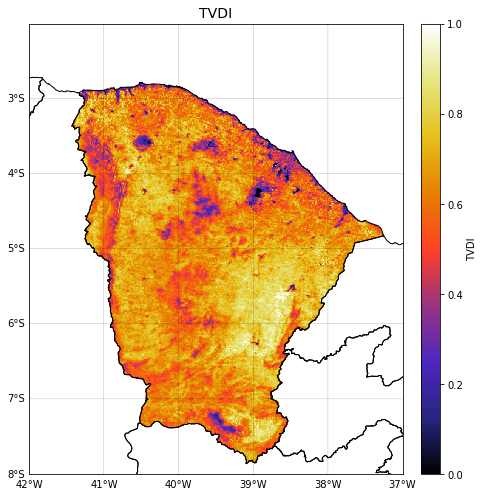

Valores próximos a 1 indicam condições secas e próximo a 0 condições úmidas


In [132]:
# Carregar imagem do TVDI gerada
dataset   = gdal.Open("./output_final/TVDI_ce.tif")
im_array  = dataset.GetRasterBand(1).ReadAsArray()
msk_array = np.ma.masked_invalid(im_array)

# Retirar matrizes lat lon
xy = dataset.GetGeoTransform() 
x, y = dataset.RasterXSize, dataset.RasterYSize    
lon_start = xy[0] 
lon_stop  = x*xy[1]+xy[0] 
lon_step  = xy[1]    
lat_start = xy[3] 
lat_stop  = y*xy[5]+xy[3] 
lat_step  = xy[5]

xx = np.arange(lon_start, lon_stop, lon_step) 
yy = np.arange(lat_start, lat_stop, lat_step)    
lons, lats = np.meshgrid(xx,yy)

# Desenhar meridianos e pararelos
plt.figure(figsize=(8,7))

m = Basemap(projection='merc', llcrnrlat=-8, urcrnrlat=-2,\
            llcrnrlon=-42, urcrnrlon=-37, resolution='l', suppress_ticks=True)

parallels = np.arange(-80., 0, 1)
m.drawparallels(parallels, labels=[True, False, False, False], linewidth=0.25)
meridians = np.arange(-350., 10, 1)
m.drawmeridians(meridians, labels=[False, False, False, True], linewidth=0.25)

# Plotar TVDI
m.readshapefile("./shapefiles/limites_estaduais_bra", 'limites', linewidth=1)
cm = m.pcolormesh(lons, lats, msk_array, vmin = 0., vmax = 1., latlon=True, cmap='CMRmap')

# Adicionar colorbar
cbar = m.colorbar(cm, location='right', pad="5%")
cbar.set_label('TVDI')
plt.title('TVDI', fontsize=14)

# Salvar figura
plt.tight_layout()
plt.savefig(path + '/TVDI_ce.png', dpi=200)
plt.show()
print("Valores próximos a 1 indicam condições secas e próximo a 0 condições úmidas")

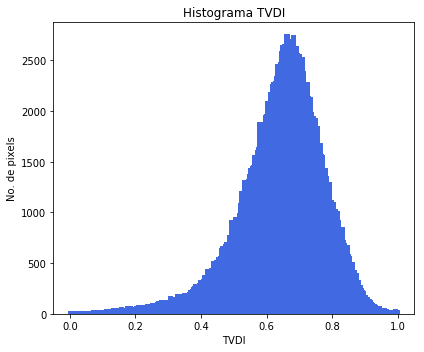

In [133]:
# Plot do histograma
plt.figure(figsize=(6,5))
plt.hist(TVDI.ravel(), bins=256, range=(0, 1), lw=4, ec='royalblue')
plt.title("Histograma TVDI")
plt.xlabel('TVDI')
plt.ylabel('No. de pixels')

# Salvar figura
plt.tight_layout()
plt.savefig(path + '/TVDI_hist_ce.png', dpi=200)
plt.show()

# Referências
DU, Lingtong et al. Comparison of two simulation methods of the temperature vegetation dryness index (TVDI) for drought monitoring in semi-arid regions of China. **Remote Sensing**, v. 9, n. 2, p. 177, 2017.

SANDHOLT, I.; RASMUSSEN, K.; ANDERSEN, J. A simple interpretation of the surface temperature/vegetation index space for assessment of surface moisture status. **Remote Sensing of environment**, v. 79, n. 2-3, p. 213-224, 2002.

SCHIRMBECK, L. W.; FONTANA, D. C.; SCHIRMBECK, J. Two approaches to calculate TVDI in humid subtropical climate of southern Brazil. **Scientia Agricola**, v. 75, n. 2, p. 111-120, 2018.

MENG, L. et al. The calculation of TVDI based on the composite time of pixel and drought analysis. **The International Archives of the Photogrammetry, Remote Sensing and Spatial Information Sciences**, v. 38, n. Part II, 2010.

# Perspectivas futuras


*   Aplicar máscara dos corpos d'água
*   Modificar o método para que o TVDI possa ser comparado ao longo do tempo e nas diferentes estações


